In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [3]:
train_path="/content/drive/MyDrive/Colab Notebooks/ts_final/train_dl_q.csv"
test_path="/content/drive/MyDrive/Colab Notebooks/ts_final/test_dl_q.csv"
sub_path = "/content/drive/MyDrive/Colab Notebooks/ts_final/submission.csv"


train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sub = pd.read_csv(sub_path)

In [4]:
print("train  ", train.shape)
print("test  ", test.shape)

train   (204000, 30)
test   (16800, 29)


In [5]:
train.columns

Index(['건물번호', '기온', '강수량', '풍속', '습도', '전력소비량', 'datetime', '태양광용량',
       'ESS저장용량', 'PCS용량', 'hour', 'day', 'weekday', 'is_weekend', 'month',
       '건물유형_건물기타', '건물유형_공공', '건물유형_백화점', '건물유형_병원', '건물유형_상용', '건물유형_아파트',
       '건물유형_연구소', '건물유형_학교', '건물유형_호텔', '연면적_log', '냉방면적_log', '불쾌지수',
       '태양광용량_exists', 'ESS저장용량_exists', 'PCS용량_exists'],
      dtype='object')

In [6]:
test.columns

Index(['건물번호', '기온', '강수량', '풍속', '습도', 'datetime', '태양광용량', 'ESS저장용량',
       'PCS용량', 'hour', 'day', 'weekday', 'is_weekend', 'month', '건물유형_건물기타',
       '건물유형_공공', '건물유형_백화점', '건물유형_병원', '건물유형_상용', '건물유형_아파트', '건물유형_연구소',
       '건물유형_학교', '건물유형_호텔', '연면적_log', '냉방면적_log', '불쾌지수', '태양광용량_exists',
       'ESS저장용량_exists', 'PCS용량_exists'],
      dtype='object')

In [7]:
test=test.reindex(columns=train.columns, fill_value = 0)

In [8]:
scal_col = ["hour", "day", "weekday", "is_weekend", "month"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
train[scal_col]=scaler.fit_transform(train[scal_col])
test[scal_col]=scaler.transform(test[scal_col])


In [10]:
train.head()

,건물번호,기온,강수량,풍속,습도,전력소비량,datetime,태양광용량,ESS저장용량,PCS용량,...,건물유형_아파트,건물유형_연구소,건물유형_학교,건물유형_호텔,연면적_log,냉방면적_log,불쾌지수,태양광용량_exists,ESS저장용량_exists,PCS용량_exists
0,1,0.326733,0.0,0.171053,0.82,0.630237,2024-06-01 00:00:00,0.0,0.0,0.0,...,False,False,False,True,0.365115,0.627371,0.390428,0,0,0
1,1,0.326733,0.0,0.177632,0.82,0.597644,2024-06-01 01:00:00,0.0,0.0,0.0,...,False,False,False,True,0.365115,0.627371,0.390428,0,0,0
2,1,0.320132,0.0,0.171053,0.80,0.556904,2024-06-01 02:00:00,0.0,0.0,0.0,...,False,False,False,True,0.365115,0.627371,0.381161,0,0,0
3,1,0.316832,0.0,0.171053,0.81,0.431037,2024-06-01 03:00:00,0.0,0.0,0.0,...,False,False,False,True,0.365115,0.627371,0.378241,0,0,0
4,1,0.310231,0.0,0.085526,0.81,0.278122,2024-06-01 04:00:00,0.0,0.0,0.0,...,False,False,False,True,0.365115,0.627371,0.370710,0,0,0


# LSTM

시퀀스 24  
rag, roll은 제거 하는것이 성능 높음  
불쾌지수 추가 시 성능 아주 약간 향상  

In [11]:
SEQ_LEN = 24  #시퀀스 길이

class SeqDataset(Dataset):
    def __init__(self, df, target_col="전력소비량"):
        self.df = df.reset_index(drop=True)
        self.target = df[target_col].values.astype(np.float32)
        self.X = df.drop(columns=[target_col, "datetime", "numdatetime","rag_1","rag_24","roll_6","roll_24"], errors="ignore").values.astype(np.float32)

    def __len__(self):
        return len(self.df) - SEQ_LEN

    def __getitem__(self, idx):
        X_seq = self.X[idx: idx + SEQ_LEN]
        y = self.target[idx + SEQ_LEN]
        return torch.tensor(X_seq), torch.tensor(y)



In [12]:
test_id_col = test["datetime"].tolist()

In [13]:
import torch.nn as nn

class LSTMSeqModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)           #(batch, seq,hidden)
        out = out[:, -1, :]
        return self.fc(out).squeeze(1)  # (batch,)


In [14]:
from sklearn.model_selection import train_test_split

train_df, val_df = train.iloc[:-40800], train.iloc[-40800:]

train_dataset = SeqDataset(train_df)
val_dataset   = SeqDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=False)

input_dim = train_dataset[0][0].shape[1]


In [15]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True


In [16]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMSeqModel(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5, patience=2)

EPOCHS = 25
early_stopping = EarlyStopping(patience=5, min_delta=0.0001)

best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader, desc="Training batches")):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

        if batch_idx % 500 == 0:
            print(f"Batch {batch_idx}: Loss={loss.item():.4f}")

    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(X_batch)
            val_loss += criterion(pred, y_batch).item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train={train_loss:.4f} | Val={val_loss:.4f}")

    early_stopping.step(val_loss)

    if early_stopping.best_loss == val_loss:
        best_model_state = model.state_dict()

    if early_stopping.stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print("Best epoch loaded.")


Epoch 1/25


Training batches:   0%|          | 4/2549 [00:00<04:09, 10.18it/s]

Batch 0: Loss=0.2589


Training batches:  20%|█▉        | 505/2549 [00:14<01:17, 26.48it/s]

Batch 500: Loss=0.0264


Training batches:  39%|███▉      | 1006/2549 [00:28<00:58, 26.52it/s]

Batch 1000: Loss=0.0336


Training batches:  59%|█████▉    | 1504/2549 [00:41<00:39, 26.71it/s]

Batch 1500: Loss=0.0106


Training batches:  79%|███████▊  | 2006/2549 [00:56<00:13, 39.14it/s]

Batch 2000: Loss=0.0151


Training batches:  98%|█████████▊| 2506/2549 [01:10<00:01, 39.33it/s]

Batch 2500: Loss=0.0155


Training batches: 100%|██████████| 2549/2549 [01:11<00:00, 35.69it/s]


Epoch 1/25 | Train=0.0269 | Val=0.0606

Epoch 2/25


Training batches:   0%|          | 4/2549 [00:00<01:06, 38.16it/s]

Batch 0: Loss=0.0194


Training batches:  20%|█▉        | 508/2549 [00:13<00:50, 40.33it/s]

Batch 500: Loss=0.0158


Training batches:  40%|███▉      | 1007/2549 [00:27<00:38, 40.48it/s]

Batch 1000: Loss=0.0124


Training batches:  59%|█████▉    | 1505/2549 [00:40<00:26, 40.14it/s]

Batch 1500: Loss=0.0101


Training batches:  79%|███████▉  | 2008/2549 [00:54<00:13, 40.59it/s]

Batch 2000: Loss=0.0215


Training batches:  98%|█████████▊| 2505/2549 [01:08<00:01, 40.68it/s]

Batch 2500: Loss=0.0066


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.78it/s]


Epoch 2/25 | Train=0.0133 | Val=0.0469

Epoch 3/25


Training batches:   0%|          | 4/2549 [00:00<01:06, 38.13it/s]

Batch 0: Loss=0.0131


Training batches:  20%|█▉        | 505/2549 [00:13<00:50, 40.38it/s]

Batch 500: Loss=0.0166


Training batches:  39%|███▉      | 1005/2549 [00:27<00:38, 40.38it/s]

Batch 1000: Loss=0.0072


Training batches:  59%|█████▉    | 1509/2549 [00:41<00:25, 40.43it/s]

Batch 1500: Loss=0.0104


Training batches:  79%|███████▊  | 2007/2549 [00:54<00:13, 39.99it/s]

Batch 2000: Loss=0.0144


Training batches:  98%|█████████▊| 2509/2549 [01:08<00:00, 40.41it/s]

Batch 2500: Loss=0.0137


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.79it/s]


Epoch 3/25 | Train=0.0108 | Val=0.0542

Epoch 4/25


Training batches:   0%|          | 3/2549 [00:00<01:48, 23.50it/s]

Batch 0: Loss=0.0147


Training batches:  20%|█▉        | 504/2549 [00:13<01:16, 26.70it/s]

Batch 500: Loss=0.0047


Training batches:  39%|███▉      | 1006/2549 [00:27<00:58, 26.20it/s]

Batch 1000: Loss=0.0183


Training batches:  59%|█████▉    | 1505/2549 [00:41<00:38, 26.94it/s]

Batch 1500: Loss=0.0081


Training batches:  79%|███████▊  | 2005/2549 [00:55<00:20, 26.19it/s]

Batch 2000: Loss=0.0157


Training batches:  98%|█████████▊| 2505/2549 [01:08<00:01, 31.85it/s]

Batch 2500: Loss=0.0046


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.43it/s]


Epoch 4/25 | Train=0.0099 | Val=0.0452

Epoch 5/25


Training batches:   0%|          | 4/2549 [00:00<01:05, 38.74it/s]

Batch 0: Loss=0.0137


Training batches:  20%|█▉        | 506/2549 [00:13<00:54, 37.82it/s]

Batch 500: Loss=0.0080


Training batches:  39%|███▉      | 1006/2549 [00:27<00:38, 40.15it/s]

Batch 1000: Loss=0.0103


Training batches:  59%|█████▉    | 1505/2549 [00:41<00:25, 40.34it/s]

Batch 1500: Loss=0.0057


Training batches:  79%|███████▉  | 2008/2549 [00:54<00:13, 40.46it/s]

Batch 2000: Loss=0.0055


Training batches:  98%|█████████▊| 2509/2549 [01:08<00:00, 40.27it/s]

Batch 2500: Loss=0.0119


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.64it/s]


Epoch 5/25 | Train=0.0087 | Val=0.0461

Epoch 6/25


Training batches:   0%|          | 4/2549 [00:00<01:07, 37.67it/s]

Batch 0: Loss=0.0041


Training batches:  20%|█▉        | 508/2549 [00:13<00:50, 40.21it/s]

Batch 500: Loss=0.0058


Training batches:  39%|███▉      | 1005/2549 [00:27<00:39, 39.03it/s]

Batch 1000: Loss=0.0058


Training batches:  59%|█████▉    | 1505/2549 [00:41<00:25, 40.64it/s]

Batch 1500: Loss=0.0135


Training batches:  79%|███████▉  | 2008/2549 [00:54<00:13, 40.23it/s]

Batch 2000: Loss=0.0053


Training batches:  98%|█████████▊| 2509/2549 [01:08<00:00, 40.40it/s]

Batch 2500: Loss=0.0100


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.66it/s]


Epoch 6/25 | Train=0.0081 | Val=0.0464

Epoch 7/25


Training batches:   0%|          | 3/2549 [00:00<01:43, 24.56it/s]

Batch 0: Loss=0.0042


Training batches:  20%|█▉        | 506/2549 [00:13<01:14, 27.38it/s]

Batch 500: Loss=0.0032


Training batches:  39%|███▉      | 1006/2549 [00:27<00:55, 27.57it/s]

Batch 1000: Loss=0.0073


Training batches:  59%|█████▉    | 1504/2549 [00:41<00:39, 26.49it/s]

Batch 1500: Loss=0.0042


Training batches:  79%|███████▊  | 2006/2549 [00:55<00:20, 26.43it/s]

Batch 2000: Loss=0.0072


Training batches:  98%|█████████▊| 2506/2549 [01:09<00:01, 26.49it/s]

Batch 2500: Loss=0.0129


Training batches: 100%|██████████| 2549/2549 [01:10<00:00, 36.21it/s]


Epoch 7/25 | Train=0.0075 | Val=0.0429

Epoch 8/25


Training batches:   0%|          | 4/2549 [00:00<01:07, 37.53it/s]

Batch 0: Loss=0.0046


Training batches:  20%|█▉        | 506/2549 [00:13<00:52, 39.13it/s]

Batch 500: Loss=0.0066


Training batches:  40%|███▉      | 1007/2549 [00:27<00:38, 40.05it/s]

Batch 1000: Loss=0.0076


Training batches:  59%|█████▉    | 1504/2549 [00:40<00:25, 40.23it/s]

Batch 1500: Loss=0.0051


Training batches:  79%|███████▊  | 2005/2549 [00:54<00:13, 40.25it/s]

Batch 2000: Loss=0.0072


Training batches:  98%|█████████▊| 2508/2549 [01:08<00:00, 41.37it/s]

Batch 2500: Loss=0.0058


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.85it/s]


Epoch 8/25 | Train=0.0073 | Val=0.0442

Epoch 9/25


Training batches:   0%|          | 4/2549 [00:00<01:06, 38.47it/s]

Batch 0: Loss=0.0050


Training batches:  20%|█▉        | 505/2549 [00:13<00:51, 39.58it/s]

Batch 500: Loss=0.0112


Training batches:  40%|███▉      | 1007/2549 [00:27<00:38, 39.71it/s]

Batch 1000: Loss=0.0067


Training batches:  59%|█████▉    | 1506/2549 [00:41<00:27, 38.12it/s]

Batch 1500: Loss=0.0055


Training batches:  79%|███████▊  | 2006/2549 [00:55<00:13, 40.05it/s]

Batch 2000: Loss=0.0068


Training batches:  98%|█████████▊| 2505/2549 [01:08<00:01, 39.30it/s]

Batch 2500: Loss=0.0121


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.49it/s]


Epoch 9/25 | Train=0.0068 | Val=0.0468

Epoch 10/25


Training batches:   0%|          | 3/2549 [00:00<01:47, 23.71it/s]

Batch 0: Loss=0.0026


Training batches:  20%|█▉        | 504/2549 [00:13<01:11, 28.77it/s]

Batch 500: Loss=0.0065


Training batches:  39%|███▉      | 1006/2549 [00:27<00:55, 27.73it/s]

Batch 1000: Loss=0.0049


Training batches:  59%|█████▉    | 1505/2549 [00:41<00:36, 28.51it/s]

Batch 1500: Loss=0.0165


Training batches:  79%|███████▊  | 2005/2549 [00:54<00:19, 28.19it/s]

Batch 2000: Loss=0.0086


Training batches:  98%|█████████▊| 2505/2549 [01:08<00:01, 27.92it/s]

Batch 2500: Loss=0.0064


Training batches: 100%|██████████| 2549/2549 [01:10<00:00, 36.31it/s]


Epoch 10/25 | Train=0.0067 | Val=0.0436

Epoch 11/25


Training batches:   0%|          | 4/2549 [00:00<01:08, 37.34it/s]

Batch 0: Loss=0.0131


Training batches:  20%|█▉        | 506/2549 [00:13<00:53, 38.09it/s]

Batch 500: Loss=0.0056


Training batches:  40%|███▉      | 1008/2549 [00:27<00:39, 39.39it/s]

Batch 1000: Loss=0.0038


Training batches:  59%|█████▉    | 1506/2549 [00:41<00:26, 39.86it/s]

Batch 1500: Loss=0.0055


Training batches:  79%|███████▉  | 2008/2549 [00:54<00:13, 40.10it/s]

Batch 2000: Loss=0.0092


Training batches:  98%|█████████▊| 2505/2549 [01:08<00:01, 39.85it/s]

Batch 2500: Loss=0.0034


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.71it/s]


Epoch 11/25 | Train=0.0063 | Val=0.0440

Epoch 12/25


Training batches:   0%|          | 4/2549 [00:00<01:08, 37.11it/s]

Batch 0: Loss=0.0045


Training batches:  20%|█▉        | 506/2549 [00:13<00:50, 40.14it/s]

Batch 500: Loss=0.0058


Training batches:  39%|███▉      | 1006/2549 [00:27<00:38, 39.92it/s]

Batch 1000: Loss=0.0082


Training batches:  59%|█████▉    | 1508/2549 [00:40<00:25, 40.11it/s]

Batch 1500: Loss=0.0049


Training batches:  79%|███████▉  | 2008/2549 [00:54<00:13, 40.21it/s]

Batch 2000: Loss=0.0080


Training batches:  98%|█████████▊| 2507/2549 [01:08<00:01, 39.84it/s]

Batch 2500: Loss=0.0071


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.83it/s]


Epoch 12/25 | Train=0.0062 | Val=0.0421

Epoch 13/25


Training batches:   0%|          | 4/2549 [00:00<01:06, 38.40it/s]

Batch 0: Loss=0.0032


Training batches:  20%|█▉        | 507/2549 [00:13<00:50, 40.21it/s]

Batch 500: Loss=0.0069


Training batches:  40%|███▉      | 1007/2549 [00:27<00:38, 40.29it/s]

Batch 1000: Loss=0.0083


Training batches:  59%|█████▉    | 1507/2549 [00:41<00:25, 40.66it/s]

Batch 1500: Loss=0.0049


Training batches:  79%|███████▉  | 2009/2549 [00:54<00:13, 40.69it/s]

Batch 2000: Loss=0.0094


Training batches:  98%|█████████▊| 2509/2549 [01:08<00:00, 40.43it/s]

Batch 2500: Loss=0.0015


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.45it/s]


Epoch 13/25 | Train=0.0059 | Val=0.0451

Epoch 14/25


Training batches:   0%|          | 4/2549 [00:00<01:06, 38.38it/s]

Batch 0: Loss=0.0031


Training batches:  20%|█▉        | 504/2549 [00:13<00:50, 40.40it/s]

Batch 500: Loss=0.0070


Training batches:  39%|███▉      | 1005/2549 [00:27<00:37, 41.02it/s]

Batch 1000: Loss=0.0052


Training batches:  59%|█████▉    | 1508/2549 [00:41<00:25, 40.60it/s]

Batch 1500: Loss=0.0088


Training batches:  79%|███████▉  | 2008/2549 [00:54<00:13, 40.21it/s]

Batch 2000: Loss=0.0070


Training batches:  98%|█████████▊| 2505/2549 [01:08<00:01, 40.71it/s]

Batch 2500: Loss=0.0039


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.67it/s]


Epoch 14/25 | Train=0.0058 | Val=0.0454

Epoch 15/25


Training batches:   0%|          | 4/2549 [00:00<01:17, 32.89it/s]

Batch 0: Loss=0.0059


Training batches:  20%|█▉        | 508/2549 [00:13<00:54, 37.77it/s]

Batch 500: Loss=0.0099


Training batches:  39%|███▉      | 1005/2549 [00:27<00:42, 36.64it/s]

Batch 1000: Loss=0.0051


Training batches:  59%|█████▉    | 1507/2549 [00:41<00:26, 39.89it/s]

Batch 1500: Loss=0.0062


Training batches:  79%|███████▊  | 2006/2549 [00:54<00:13, 40.40it/s]

Batch 2000: Loss=0.0120


Training batches:  98%|█████████▊| 2506/2549 [01:08<00:01, 39.00it/s]

Batch 2500: Loss=0.0093


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.84it/s]


Epoch 15/25 | Train=0.0057 | Val=0.0446

Epoch 16/25


Training batches:   0%|          | 4/2549 [00:00<01:07, 37.53it/s]

Batch 0: Loss=0.0037


Training batches:  20%|█▉        | 508/2549 [00:13<00:50, 40.45it/s]

Batch 500: Loss=0.0021


Training batches:  40%|███▉      | 1009/2549 [00:27<00:38, 39.85it/s]

Batch 1000: Loss=0.0053


Training batches:  59%|█████▉    | 1509/2549 [00:41<00:25, 40.24it/s]

Batch 1500: Loss=0.0084


Training batches:  79%|███████▊  | 2007/2549 [00:54<00:13, 40.05it/s]

Batch 2000: Loss=0.0061


Training batches:  98%|█████████▊| 2509/2549 [01:08<00:00, 40.53it/s]

Batch 2500: Loss=0.0031


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.63it/s]


Epoch 16/25 | Train=0.0056 | Val=0.0511

Epoch 17/25


Training batches:   0%|          | 4/2549 [00:00<01:05, 38.72it/s]

Batch 0: Loss=0.0025


Training batches:  20%|█▉        | 506/2549 [00:13<00:51, 39.81it/s]

Batch 500: Loss=0.0025


Training batches:  40%|███▉      | 1008/2549 [00:27<00:38, 40.39it/s]

Batch 1000: Loss=0.0043


Training batches:  59%|█████▉    | 1507/2549 [00:41<00:25, 40.34it/s]

Batch 1500: Loss=0.0028


Training batches:  79%|███████▉  | 2008/2549 [00:54<00:13, 40.50it/s]

Batch 2000: Loss=0.0036


Training batches:  98%|█████████▊| 2507/2549 [01:08<00:01, 40.41it/s]

Batch 2500: Loss=0.0038


Training batches: 100%|██████████| 2549/2549 [01:09<00:00, 36.69it/s]


Epoch 17/25 | Train=0.0054 | Val=0.0447
Early stopping at epoch 17
Best epoch loaded.


# LSTM

학습률 0.001  => 16.1961218482  
에폭 25, 브레이크 적용   

예측루프

In [17]:

last_values_dict = {}

for b_id, df_b in train.groupby("건물번호"):
    last_values_dict[b_id] = df_b["전력소비량"].values[-24:].tolist()

for b in last_values_dict:
    print(b, last_values_dict[b][:5])


print("done")


1 [0.4861485835421084, 0.4486702640200424, 0.2965070341106186, 0.1932019656966659, 0.2455820003854307]
2 [0.3066915448318167, 0.3145383907575912, 0.2381913914732644, 0.2439423371843369, 0.230549023617217]
3 [0.2935179721118972, 0.3281758687681098, 0.3272310150712453, 0.3228316436475995, 0.3435720111128055]
4 [0.2271640363462457, 0.2287183165949306, 0.1920133907221424, 0.2027737924438067, 0.2485652797704446]
5 [0.4515728476821192, 0.4402317880794703, 0.4299668874172186, 0.4195364238410596, 0.411341059602649]
6 [0.0903219938148081, 0.0734036747316718, 0.0875022739676187, 0.0714935419319628, 0.0851373476441695]
7 [0.8654321620928442, 0.8867145421903052, 0.8819851243908695, 0.8949217748140549, 0.9046883816363168]
8 [0.341948310139165, 0.3306825712392313, 0.3277004638833665, 0.3207422133863485, 0.3048376408217362]
9 [0.1917393538600322, 0.1820542107707946, 0.184738045602752, 0.1676319645626089, 0.213162908325498]
10 [0.2323844966685465, 0.148396748582486, 0.1365689913108669, 0.1256064325925

In [18]:
model.eval()
test_preds_all = []
test_bids_all = []

seq_len = 24


feature_cols = train_df.drop(columns=["전력소비량", "datetime", "numdatetime","rag_1","rag_24","roll_6","roll_24"], errors="ignore").columns

for b_id, test_b in test.groupby("건물번호"):

    print(f"[Predicting Building {b_id}]")
    test_b = test_b.sort_values("datetime").reset_index(drop=True) #건물별 시간순 정렬

    last_vals = last_values_dict[b_id].copy()

    preds = []
    test_bids = []

    # autoregressive
    for i in range(len(test_b)):



        if i == 0:
            print("last_vals 스케일링여부 확인")
            print("[DEBUG] 초기 last_vals[:5] =", last_vals[:5])



        row = test_b.iloc[i].copy()




        ## 오버피팅이 심한 듯해 제외
        # === lag/roll 갱신 ===

        #row["lag_1"]  = last_vals[-1]
        #row["lag_24"] = last_vals[-24]
        #row["roll_6"]  = np.mean(last_vals[-6:])
        #row["roll_24"] = np.mean(last_vals[-24:])


        seq_start = i - (seq_len - 1)
        if seq_start < 0:
            need = -seq_start
            past = train[train["건물번호"] == b_id].sort_values("datetime").iloc[-need:]
            seq_df = pd.concat([past, test_b.iloc[:i+1]], axis=0)
        else:
            seq_df = test_b.iloc[seq_start:i+1]


        if len(seq_df) > seq_len:
            seq_df = seq_df.iloc[-seq_len:]

        if len(seq_df) < seq_len:
            pad_row = seq_df.iloc[[-1]].copy()
            while len(seq_df) < seq_len:
                seq_df = pd.concat([pad_row, seq_df], axis=0)
            seq_df = seq_df.iloc[-seq_len:]

        seq_df = seq_df.copy()

        # 컬럼재정렬
        row = row.reindex(seq_df.columns)
        seq_df.iloc[-1] = row

        seq_feat = seq_df[feature_cols].copy()
        seq_feat = seq_feat.fillna(0.0)

        #X_seq = seq_df[feature_cols].values.astype(np.float32)
        #X_seq = torch.tensor(X_seq).unsqueeze(0).to(device)
        X_seq = torch.tensor(seq_feat.values.astype(np.float32)).unsqueeze(0).to(device)


        # 예측
        with torch.no_grad():
            pred = model(X_seq).item()

        if np.isnan(pred):
            print(f"⚠ NaN prediction detected: building {b_id}, step {i}")
            print("  last_vals:", last_vals[-5:])
            print("  seq_feat sample row:", seq_feat.tail(1))
            pred = 0.0

        preds.append(pred)
        test_bids.append(b_id)

        #autoregressive 업데이트
        last_vals.append(pred)
        last_vals = last_vals[-24:]


    test_preds_all.extend(preds)
    test_bids_all.extend(test_bids)


[Predicting Building 1]
last_vals 스케일링여부 확인
[DEBUG] 초기 last_vals[:5] = [0.4861485835421084, 0.4486702640200424, 0.2965070341106186, 0.1932019656966659, 0.2455820003854307]
[Predicting Building 2]
last_vals 스케일링여부 확인
[DEBUG] 초기 last_vals[:5] = [0.3066915448318167, 0.3145383907575912, 0.2381913914732644, 0.2439423371843369, 0.230549023617217]
[Predicting Building 3]
last_vals 스케일링여부 확인
[DEBUG] 초기 last_vals[:5] = [0.2935179721118972, 0.3281758687681098, 0.3272310150712453, 0.3228316436475995, 0.3435720111128055]
[Predicting Building 4]
last_vals 스케일링여부 확인
[DEBUG] 초기 last_vals[:5] = [0.2271640363462457, 0.2287183165949306, 0.1920133907221424, 0.2027737924438067, 0.2485652797704446]
[Predicting Building 5]
last_vals 스케일링여부 확인
[DEBUG] 초기 last_vals[:5] = [0.4515728476821192, 0.4402317880794703, 0.4299668874172186, 0.4195364238410596, 0.411341059602649]
[Predicting Building 6]
last_vals 스케일링여부 확인
[DEBUG] 초기 last_vals[:5] = [0.0903219938148081, 0.0734036747316718, 0.0875022739676187, 0.07149354

In [19]:
print("seq_df columns:", seq_df.columns.tolist())
print("row index:", row.index.tolist())

seq_df columns: ['건물번호', '기온', '강수량', '풍속', '습도', '전력소비량', 'datetime', '태양광용량', 'ESS저장용량', 'PCS용량', 'hour', 'day', 'weekday', 'is_weekend', 'month', '건물유형_건물기타', '건물유형_공공', '건물유형_백화점', '건물유형_병원', '건물유형_상용', '건물유형_아파트', '건물유형_연구소', '건물유형_학교', '건물유형_호텔', '연면적_log', '냉방면적_log', '불쾌지수', '태양광용량_exists', 'ESS저장용량_exists', 'PCS용량_exists']
row index: ['건물번호', '기온', '강수량', '풍속', '습도', '전력소비량', 'datetime', '태양광용량', 'ESS저장용량', 'PCS용량', 'hour', 'day', 'weekday', 'is_weekend', 'month', '건물유형_건물기타', '건물유형_공공', '건물유형_백화점', '건물유형_병원', '건물유형_상용', '건물유형_아파트', '건물유형_연구소', '건물유형_학교', '건물유형_호텔', '연면적_log', '냉방면적_log', '불쾌지수', '태양광용량_exists', 'ESS저장용량_exists', 'PCS용량_exists']


In [20]:
test_preds_all

[0.3387073874473572,
 0.2958868443965912,
 0.2630373537540436,
 0.2433851957321167,
 0.23722107708454132,
 0.2685794234275818,
 0.3858394920825958,
 0.5680215358734131,
 0.7118181586265564,
 0.7746852040290833,
 0.8037632703781128,
 0.8164694905281067,
 0.820739209651947,
 0.8222132325172424,
 0.8219134211540222,
 0.8214878439903259,
 0.819981038570404,
 0.816703736782074,
 0.7946476340293884,
 0.717592716217041,
 0.5986642241477966,
 0.5527046322822571,
 0.5031278133392334,
 0.42574775218963623,
 0.35793137550354004,
 0.31707844138145447,
 0.28223881125450134,
 0.24581147730350494,
 0.219161257147789,
 0.22992897033691406,
 0.314969003200531,
 0.4667344093322754,
 0.5854970812797546,
 0.6401432752609253,
 0.6562261581420898,
 0.6637493968009949,
 0.6788896322250366,
 0.7009603977203369,
 0.7242458462715149,
 0.7446773648262024,
 0.7574948072433472,
 0.7556320428848267,
 0.7151842713356018,
 0.5864202976226807,
 0.5666295886039734,
 0.6123277544975281,
 0.5415776968002319,
 0.440762400

In [21]:
s=0
for i in test_preds_all:
  if i == 0.0:
    s+=1
print(s)

0


In [22]:
sub["answer"] = test_preds_all


In [23]:
sub

,num_date_time,answer
0,1_20240825 00,0.338707
1,1_20240825 01,0.295887
2,1_20240825 02,0.263037
3,1_20240825 03,0.243385
4,1_20240825 04,0.237221
...,...,...
16795,100_20240831 19,0.555350
16796,100_20240831 20,0.517380
16797,100_20240831 21,0.476060
16798,100_20240831 22,0.444136


In [24]:

df = sub.copy()

df[["building", "date_hour"]] = df["num_date_time"].str.split("_", expand=True)
df[["date", "hour"]] = df["date_hour"].str.split(" ", expand=True)
df = df.drop(columns=["date_hour"])

df["building"] = df["building"].astype(int)
df["datetime"] = pd.to_datetime(df["date"] + " " + df["hour"] + ":00")

In [25]:
df

,num_date_time,answer,building,date,hour,datetime
0,1_20240825 00,0.338707,1,20240825,00,2024-08-25 00:00:00
1,1_20240825 01,0.295887,1,20240825,01,2024-08-25 01:00:00
2,1_20240825 02,0.263037,1,20240825,02,2024-08-25 02:00:00
3,1_20240825 03,0.243385,1,20240825,03,2024-08-25 03:00:00
4,1_20240825 04,0.237221,1,20240825,04,2024-08-25 04:00:00
...,...,...,...,...,...,...
16795,100_20240831 19,0.555350,100,20240831,19,2024-08-31 19:00:00
16796,100_20240831 20,0.517380,100,20240831,20,2024-08-31 20:00:00
16797,100_20240831 21,0.476060,100,20240831,21,2024-08-31 21:00:00
16798,100_20240831 22,0.444136,100,20240831,22,2024-08-31 22:00:00


In [26]:
scale_info = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ts_final/b_scale_info.csv") #건물별 min/max값
scale_dict = {int(r["건물번호"]): (r["min"], r["max"]) for _, r in scale_info.iterrows()}


In [27]:
print(scale_dict.keys())           # 건물번호 전부 있는지
print(scale_dict[b_id])            # min,max 정상 저장됐는지

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])
(np.float64(826.68), np.float64(3439.08))


In [28]:

def inverse_scale(value, b_id):
    y_min, y_max = scale_dict[b_id]
    return value * (y_max - y_min) + y_min


df["answer"] = df.apply(lambda row: inverse_scale(row["answer"], row["building"]), axis=1)


In [29]:
df

,num_date_time,answer,building,date,hour,datetime
0,1_20240825 00,3979.503160,1,20240825,00,2024-08-25 00:00:00
1,1_20240825 01,3712.868203,1,20240825,01,2024-08-25 01:00:00
2,1_20240825 02,3508.320994,1,20240825,02,2024-08-25 02:00:00
3,1_20240825 03,3385.950937,1,20240825,03,2024-08-25 03:00:00
4,1_20240825 04,3347.568203,1,20240825,04,2024-08-25 04:00:00
...,...,...,...,...,...,...
16795,100_20240831 19,2277.476355,100,20240831,19,2024-08-31 19:00:00
16796,100_20240831 20,2178.282420,100,20240831,20,2024-08-31 20:00:00
16797,100_20240831 21,2070.340164,100,20240831,21,2024-08-31 21:00:00
16798,100_20240831 22,1986.940948,100,20240831,22,2024-08-31 22:00:00


In [30]:
sub["answer"] = df["answer"]

In [31]:
sub

,num_date_time,answer
0,1_20240825 00,3979.503160
1,1_20240825 01,3712.868203
2,1_20240825 02,3508.320994
3,1_20240825 03,3385.950937
4,1_20240825 04,3347.568203
...,...,...
16795,100_20240831 19,2277.476355
16796,100_20240831 20,2178.282420
16797,100_20240831 21,2070.340164
16798,100_20240831 22,1986.940948


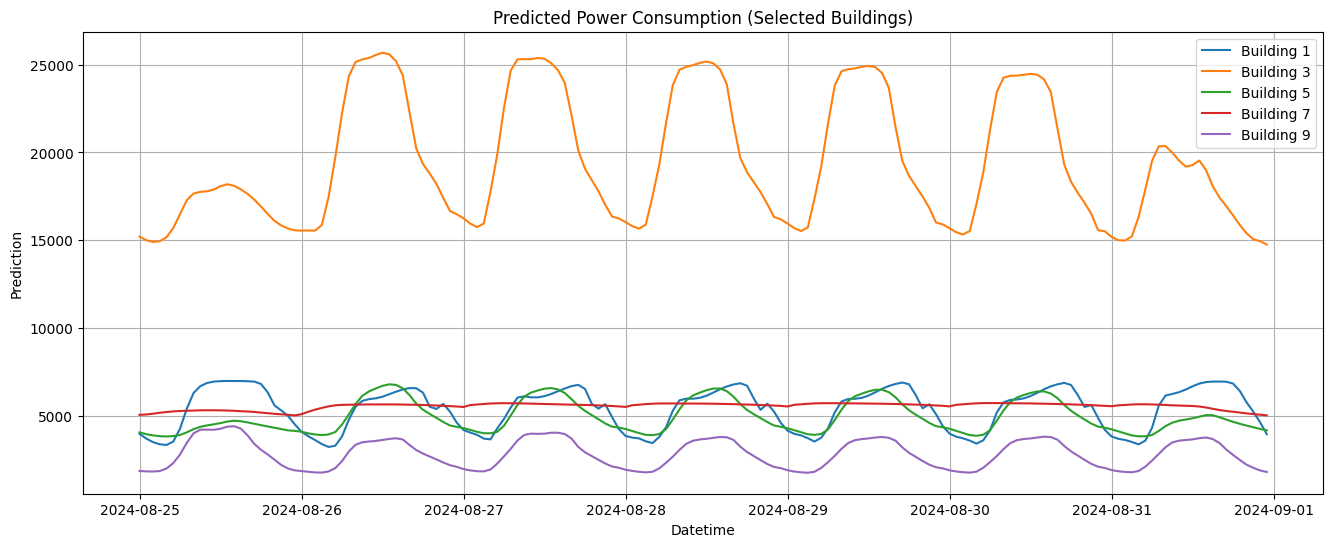

In [32]:
import matplotlib.pyplot as plt

selected_buildings = [1, 3, 5, 7, 9]

plt.figure(figsize=(16, 6))

for b in selected_buildings:
    temp = df[df["building"] == b]
    plt.plot(temp["datetime"], temp["answer"], label=f"Building {b}")

plt.title("Predicted Power Consumption (Selected Buildings)")
plt.xlabel("Datetime")
plt.ylabel("Prediction")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
sub.to_csv("./sub_LSTM_outRR.csv", index=False)